# Loan Eligibility Predictor 

In [56]:
# Dependencies
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path
from utils import *
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve

### Data 

In [57]:
# Datasets 
train_data_path = Path("./dataset/train.csv") 
test_data_path = Path("./dataset/test.csv") 
train_data = pd.read_csv(train_data_path, encoding='utf-8', index_col='Loan_ID')
test_data = pd.read_csv(test_data_path, encoding='utf-8', index_col='Loan_ID')

train_data = train_data.drop('Credit_History', axis=1)
test_data = test_data.drop('Credit_History', axis=1)

In [58]:
# Missing column in test_data
print(list(set(train_data.columns) - set(test_data.columns))[0])

Loan_Status


In [59]:
# DataFrame Shape Comparision
train_data.shape, train_data.dropna().shape

((614, 11), (523, 11))

In [60]:
df_NaN_Status(train_data)

Gender              	13/614
Married             	 3/614
Dependents          	15/614
Education           	 0/614
Self_Employed       	32/614
ApplicantIncome     	 0/614
CoapplicantIncome   	 0/614
LoanAmount          	22/614
Loan_Amount_Term    	14/614
Property_Area       	 0/614
Loan_Status         	 0/614


### Data Fetch and Engineering

In [61]:
X_train, y_train, X_test = get_train_test_data(train_data, test_data)

In [62]:
X_train.dtypes

Gender                   int64
Married                  int64
Dependents               int64
Education                int64
Self_Employed            int64
ApplicantIncome        float64
CoapplicantIncome      float64
LoanAmount             float64
Loan_Amount_Term       float64
Property_Area            int64
Total_Income           float64
EMI                    float64
DTI                    float64
Debt_to_Income         float64
Income_Per_Capita      float64
Income_to_EMI_Ratio    float64
dtype: object

### Model (Random Forrest and Logistic Regression Models)

In [63]:
models = {
    'LogisticRegression': LogisticRegression(tol=0.0001, fit_intercept=True, verbose=False), 
    'RandomForrestClassifierParameterized': RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=4, min_samples_split=10, random_state=42), 
    'RandomForrestClassifierDefault': RandomForestClassifier(n_estimators=100, random_state=42, warm_start=True, class_weight='balanced'), # Best performing
    'RandomForrestClassifierParloured': RandomForestClassifier(n_estimators=300, max_features=int(0.4 * len(X_train.columns)),
                                                            random_state=42, warm_start=True, class_weight='balanced', max_leaf_nodes=5) 
}
model = models['RandomForrestClassifierDefault']
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42,
                       warm_start=True)

### Hyperparameter tuning (for best model param selection)

In [64]:
# Testing different hyperparameters for best model selection
hyperparam_grid = {
    'n_estimators'      : [100, 200, 300],
    'max_depth'         : [None, 10, 20, 30],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf'  : [1, 2, 4]
}

# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), hyperparam_grid, cv=5, scoring='f1')
# grid_search.fit(X_train, y_train)
# print("Best Parameters:", grid_search.best_params_)

# RECENT TESTED: 
# Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

### Model Evalutation (Regression Models)

In [65]:
# Cross Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_ * 100
}).sort_values('importance', ascending=False, ignore_index=True)

print("\nFeature Importance: ")
print(feature_importance)


Cross-validation scores: [0.6504065  0.69105691 0.68292683 0.6504065  0.66393443]
Average CV score: 0.6677462348393975

Feature Importance: 
                feature  importance
0          Total_Income   11.001374
1       ApplicantIncome   10.958633
2     Income_Per_Capita   10.867810
3        Debt_to_Income   10.524423
4   Income_to_EMI_Ratio    9.607606
5                   DTI    9.260054
6                   EMI    9.190923
7            LoanAmount    8.979866
8     CoapplicantIncome    6.630762
9         Property_Area    3.250206
10           Dependents    2.785275
11              Married    1.828192
12            Education    1.629488
13     Loan_Amount_Term    1.453255
14               Gender    1.186473
15        Self_Employed    0.845659


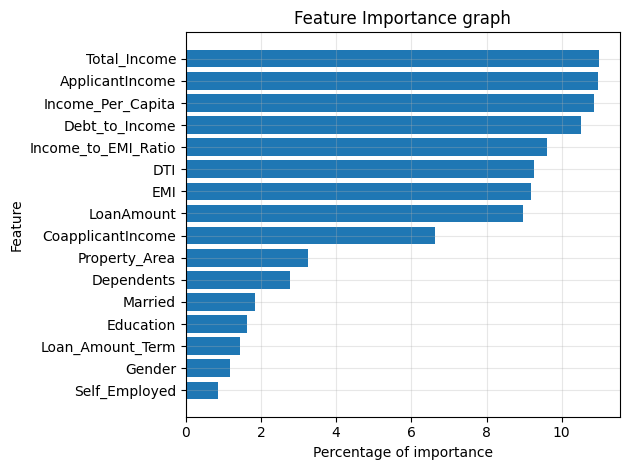

In [66]:
# Plot feature importances 
_feature_importance = feature_importance.sort_values(by='importance', ascending=True)
plt.barh(_feature_importance['feature'], _feature_importance['importance'])
plt.title("Feature Importance graph")
plt.xlabel("Percentage of importance")
plt.ylabel("Feature")
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [67]:
# F1 Score
y_pred = model.predict(X_train)
f1 = f1_score(y_true=y_train, y_pred=y_pred)

print("F1 Score: ", f1)

# Confusion matrix
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
print("\nConfustion Matrix: \t")
print(cm)

F1 Score:  1.0

Confustion Matrix: 	
[[192   0]
 [  0 422]]


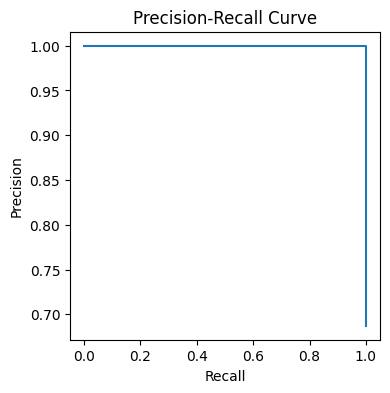

ROC-AUC Score: 1.0


In [68]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_train, model.predict_proba(X_train)[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
print(f'ROC-AUC Score: {roc_auc}')

Loan_Approval_Status
Y    84.196185
N    15.803815
Name: proportion, dtype: float64


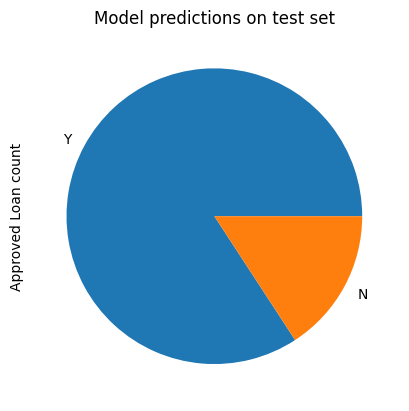

In [69]:
# Test predicitons with test dataset 
test_predictions = model.predict(X_test)
test_predictions_proba = model.predict_proba(X_test)

# Save predictions
predictions_df = pd.DataFrame({
    'Loan_ID': test_data.index,
    'Loan_Approval_Status': ['Y' if pred == 1 else 'N' for pred in test_predictions],
    'Confidence (%)': test_predictions_proba[:, 1]
})

print(predictions_df['Loan_Approval_Status'].value_counts(normalize=True) * 100)

predictions_pie = predictions_df['Loan_Approval_Status'].value_counts()\
    .plot(kind='pie', title='Model predictions on test set', ylabel="Approved Loan count")

### Test on sample data

In [70]:
# Example usage
sample_input = {
    'Gender'            : 'Male', 
    'Married'           : 'Yes', 
    'Dependents'        : '1',
    'Education'         : 'Graduate', 
    'Self_Employed'     : 'Yes',
    'ApplicantIncome'   : 50000, 
    'CoapplicantIncome' : 1000,
    'LoanAmount'        : 1000, 
    'Loan_Amount_Term'  : 60,
    'Property_Area'     : 'Rural'
}
status, confidence = predict_loan_eligibility(model, sample_input)
print(f"Loan Status: {status}, Confidence of approval: {confidence:.2%}")

Loan Status: Y, Confidence of approval: 70.00%


### Save the model 

In [71]:
save_model(model=model, fp="/Users/samarth/Programming/Loaner/model/loanPredictorModel.pkl")

### Model (Neural Network)

In [72]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [73]:
def nn_preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Preprocessing pipeline specifically for neural network"""
    df = impute_data(df)
    
    # One-hot encode categorical features
    categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 
                       'Self_Employed', 'Property_Area']
    numerical_cols = [col for col in df.columns if col not in categorical_cols]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ])
    
    processed = preprocessor.fit_transform(df)
    return processed

In [74]:
# Processed data for nn
X_train_nn = nn_preprocess_data(train_data.drop('Loan_Status', axis=1))
X_test_nn = nn_preprocess_data(test_data)
y_train_nn = LabelEncoder().fit_transform(train_data['Loan_Status'])

In [75]:
# Model Architecture
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model with adam opt and bce loss
model_nn.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(), 
                        tf.keras.metrics.BinaryAccuracy()])

### Training NN Model 

In [77]:
# Train with early stop
early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
history = model_nn.fit(
    X_train_nn, y_train_nn,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4543 - binary_accuracy: 0.4543 - loss: 0.7247 - precision_10: 0.6660 - recall_10: 0.3693 - val_accuracy: 0.6748 - val_binary_accuracy: 0.6748 - val_loss: 0.6546 - val_precision_10: 0.6803 - val_recall_10: 0.9881
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6428 - binary_accuracy: 0.6428 - loss: 0.6525 - precision_10: 0.6732 - recall_10: 0.9062 - val_accuracy: 0.6829 - val_binary_accuracy: 0.6829 - val_loss: 0.6460 - val_precision_10: 0.6829 - val_recall_10: 1.0000
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6803 - binary_accuracy: 0.6803 - loss: 0.6117 - precision_10: 0.6868 - recall_10: 0.9821 - val_accuracy: 0.6829 - val_binary_accuracy: 0.6829 - val_loss: 0.6497 - val_precision_10: 0.6829 - val_recall_10: 1.0000
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7079 - binary_accuracy: 0.7079 - loss: 0.6092 - precision_10: 0.7128 - recall_10: 0.9872 - val_accuracy

### Model Evalutation (Neural Network)

In [81]:
nn_pred_proba = model_nn.predict(X_train_nn).flatten()
nn_pred = (nn_pred_proba > 0.5).astype(int)
print(f"Neural Network F1 Score: {f1_score(y_train_nn, nn_pred)}")
print(f"ROC-AUC Score: {roc_auc_score(y_train_nn, nn_pred_proba)}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
Neural Network F1 Score: 0.8146718146718147
ROC-AUC Score: 0.5615373222748815


In [84]:
confusion_matrix(y_true=y_train_nn, y_pred=nn_pred)

array([[  0, 192],
       [  0, 422]])